## Homework

Write a generator for electron - positron pairs from the Z boson decay. Assume the Z boson is at rest, and its mass is ditributed according to the 
Breit-Wigner (BW) distribution with $m_{Z} = 92.1876$, $\Gamma = 2.4952$.

* generate events with the pair energy in range [50,200]
* assume the decay is isotropic (is this fully correct?)
* generate at least 500k events. How long it takes? What is the generation effciency?
* plot histogram of the pair invariant mass with linear and log Y scales. Overlay with probability distribution for invariant mass
* plot histogram of  $cos(\theta)$ of electrons moementum
* plot histogram of transverse electron momentum $p_{T}$. Overlay with probability distribution for transverse momentum.

**Hints:** 
* the probability distibution for the $p_{T}$ can be obtained from the chain rule:

\begin{equation}
\frac{d\sigma}{dp_{T}} =  \frac{d\sigma}{d\cos(\theta)} \frac{d\cos(\theta)}{dp_{T}}
\end{equation}

* use the nominal Z boson mass while calculating the $\frac{d\sigma}{dp_{T}}$.

Setup of our environment

In [7]:
#import ROOT

#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np

#HEP specific tools
import scipy.constants as scipy_constants

#Plotting libraries
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [8]:
G_F = scipy_constants.physical_constants["Fermi coupling constant"]
m_e = scipy_constants.physical_constants["electron mass energy equivalent in MeV"]
m_mu = scipy_constants.physical_constants["muon mass energy equivalent in MeV"]

print("Fermi constant: {} +- {} {}".format(G_F[0], G_F[2], G_F[1]))
print("muon mass: \t{} +- {} {}".format(m_mu[0], m_mu[2], m_mu[1]))
print("electron mass: \t{} +- {} {}".format(m_e[0], m_e[2], m_e[1]))

G_F = G_F[0]
m_e = m_e[0]
m_mu = m_mu[0]

Fermi constant: 1.1663787e-05 +- 6e-12 GeV^-2
muon mass: 	105.6583755 +- 2.3e-06 MeV
electron mass: 	0.51099895 +- 1.5e-10 MeV


## Our homework functions

In [3]:
minS = 50
maxS = 200

m_Z = 92.1876
gamma_Z = 2.4952

def BreitWigner(s, m, gamma):
    gamma_small = np.sqrt(m ** 2 * (m ** 2 + gamma ** 2))
    k = (2 * np.sqrt(2) * m * gamma * gamma_small) / (np.pi * np.sqrt(m ** 2 + gamma_small))
    
    distr = k / ((s ** 2 - m ** 2) ** 2 + m ** 2 * gamma ** 2)
    return distr

def generateCandidateEnergy(nPoints):
    gamma = gamma_Z
    s = (maxS-minS)*np.random.random(nPoints) + minS
    print(s)
    x = np.random.random_sample(nPoints)
    bw_values = BreitWigner(s, m_Z, gamma)  # it is equivalent to p
    bw_values = bw_values / np.max(bw_values)
    accepted = x < bw_values
    return s[accepted]/2.0

def generateCandidateMomenta(energy):
    howmany = len(energy)
    
    c = np.random.random_sample([howmany, 3]) 
    csum = np.sum(c, axis=1)  # we need to generate shoots so that their sum equals energy
    cdiv = np.asanyarray(1 / csum)  # vector we multiply our matrix
    cdivT = np.vstack(cdiv)  # transposed vector

    result = np.multiply(c, cdivT)  # matrix multiplied  by sum
    energyT = np.vstack(energy)  # transposed vector of energies
    
    p = np.multiply(result, energyT)    # we multiply our matrix by energy to get sum of momenta equal to energy
    
    px = p[:, 0]    # our momenta
    py = p[:, 1]
    pz = p[:, 2]
   
    p4_electron = np.column_stack([energy, px,py,pz])
    p4_positron = np.column_stack([energy, -px,-py,-pz])
    return  p4_electron, p4_positron

def generateEvents(nPoints):
    energy = generateCandidateEnergy(nPoints)
    data = generateCandidateMomenta(energy)
    return data

def invMass(p4):
    metric = np.array([1,-1,-1,-1])
    p4_square = p4*(metric*p4)
    m = np.sqrt(np.sum(p4_square, axis=1))
    return m

def pdf_invMass(m, m_Z, gamma_Z):
    p = np.where(np.logical_and(m>50, m<200), BreitWigner(m, m_Z, gamma_Z), 0)
    return p


## Here are energies generated

In [15]:
nPoints = 500000

e_min = 50
e_max = 200

energies = generateCandidateEnergy(nPoints)
print("Number of accepted events:\t",energies.shape[0])
print("Accepted events fraction:\t",energies.shape[0]/nPoints)

[119.61989755  80.59509846 126.68207618 ...  58.117843    52.14118562
 162.33303344]
Number of accepted events:	 12972
Accepted events fraction:	 0.025944


## Here are momenta generated


In [16]:
b = generateCandidateMomenta(energies)

## Result plots

[123.29885243  78.50754971 148.11604097 ... 175.39805815 135.00146054
  63.00586227]
Generated 26104 events for 1000000 tries. 
Efficiency: 0.03


<timed exec>:45: RuntimeWarning: invalid value encountered in sqrt


CPU times: user 501 ms, sys: 12 ms, total: 513 ms
Wall time: 510 ms


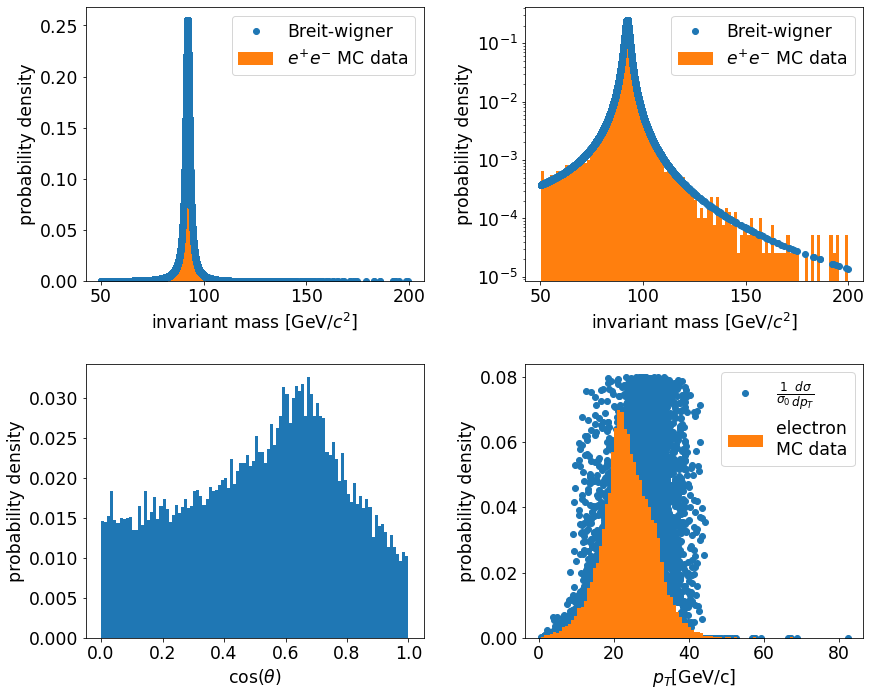

In [21]:
%%time

nPoints = 1000000
p4_electron, p4_positron = generateEvents(nPoints)
m = invMass(p4_electron + p4_positron)
print("Generated {} events for {} tries. \nEfficiency: {:3.2f}".format(m.shape[0], nPoints, float(m.shape[0])/nPoints))

fig, axes = plt.subplots(2,2, figsize=(12, 12))
axes[0,0].plot(m, BreitWigner(m, m_Z, gamma_Z), "o",label="Breit-wigner");
axes[0,0].hist(m, bins=100, density=True, label=r"$e^{+}e^{-}$ MC data");
axes[0,0].set_xlabel(r"invariant mass [GeV/$c^{2}$]")
axes[0,0].set_ylabel("probability density")
axes[0,0].legend(loc="upper right");

axes[0,1].plot(m, BreitWigner(m, m_Z, gamma_Z), "o",label="Breit-wigner");
axes[0,1].hist(m, bins=100, density=True, label=r"$e^{+}e^{-}$ MC data");
axes[0,1].set_xlabel(r"invariant mass [GeV/$c^{2}$]")
axes[0,1].set_ylabel("probability density")
axes[0,1].set_yscale("log")
axes[0,1].legend(loc="upper right");

pT = np.sqrt(np.sum(p4_electron[:,1:3]*p4_electron[:,1:3], axis=1))
pL = p4_electron[:,3]
p = np.sqrt(p4_electron[:, 1] ** 2 + p4_electron[:, 2] ** 2 + p4_electron[:, 3] ** 2)

cosTheta = pL/p     # calculated cosine theta
pTnew = p * (np.sqrt(1 - cosTheta ** 2))     # pT needed to calculate the derivative of cosine theta over pT
dpTcosTheta =  - p * cosTheta / np.sqrt(1 - cosTheta ** 2)
invdpTcosTheta = 1 / dpTcosTheta  # inverse derivative

# Here I create probability distribution of cosTheta
(counts, bins) = np.histogram(cosTheta, bins=100)
sumcos = np.sum(cosTheta)
normalizaiton = 1 / sumcos

axes[1,0].hist(bins[:-1], bins, weights=normalizaiton*counts, label="electrons");
axes[1,0].set_xlabel(r"$\cos(\theta)$")
axes[1,0].set_ylabel("probability density")

unicos = np.random.uniform(0, 1, size=len(invdpTcosTheta))  # probability distribution of cosTheta 
g = -unicos * invdpTcosTheta
pT_dist = g
pT_dist = np.where(pT_dist<0.08, pT_dist, 0)

pT_dist2 = pT / (m_Z/2) ** 2/ np.sqrt(1-(pT / (m_Z/2)) ** 2)
pT_dist2 = np.where(pT_dist2<0.08, pT_dist, 0)

# plt.plot(pTnew, pT_dist, "o")

# pT_dist = ...
# pT_dist = np.where(pT_dist<0.08, pT_dist, 0)
axes[1,1].plot(pTnew, pT_dist2,"o" ,label=r"$\frac{1}{\sigma_{0}}\frac{d\sigma}{dp_{T}}$", zorder=1);
axes[1,1].hist(pTnew, bins=100, density=True, label="electron\nMC data", zorder=2);
axes[1,1].set_xlabel(r"$p_{T}$[GeV/c]")
axes[1,1].set_ylabel("probability density")
axes[1,1].legend(loc="upper right");

plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.3, hspace=0.3)

### Test plots

In [ ]:
b = -cosTheta * invdpTcosTheta

# Here I create probability distribution of cosTheta
(counts, bins) = np.histogram(cosTheta, bins=100)
sumcos = np.sum(cosTheta)
normalizaiton = 1 / sumcos

# normar = np.ones(len(b)) * normalizaiton

# r = plt.hist(b, bins=100, weights=normar)
pT_dist = b
pT_dist = np.where(pT_dist<0.08, pT_dist, 0)

plt.plot(pTnew, b, 'o')

# plt.plot(pTnew, r[1])

# axes[1,0].hist(bins[:-1], bins, weights=normalizaiton*counts, label="electrons");
# axes[1,0].set_xlabel(r"$\cos(\theta)$")
# axes[1,0].set_ylabel("probability density")

NameError: name 'cosTheta' is not defined